For questions 1 and 2: 

Given a dataset with time series data containing an event, use a linear regression to test whether there was a discontinuity in the data at the event. Consider the possibility, first, of a discontinuity only in the value of the variable but not the derivative. Then consider that there may be a discontinuity in the first derivative (the slope).  
Use the file homework_3.1.csv. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df_3_1 = pd.read_csv('homework_3.1.csv')
print("Data shape:", df_3_1.shape)
print("\nFirst few rows:")
print(df_3_1.head(10))

print("\nData around the event (time = 50):")
around_event = df_3_1[(df_3_1['time'] >= 45) & (df_3_1['time'] <= 55)]
print(around_event)

print("\nData summary:")
print(df_3_1.describe())

Data shape: (100, 5)

First few rows:
   Unnamed: 0  time    value1    value2    value3
0           0     0  1.764052  1.883151 -0.369182
1           1     1  0.420157 -1.327759 -0.219379
2           2     2  1.018738 -1.230485  1.139660
3           3     3  2.300893  1.029397  0.715264
4           4     4  1.947558 -1.093123  0.720132
5           5     5 -0.877278  2.043621 -1.516956
6           6     6  1.070088 -0.293619  0.095674
7           7     7 -0.011357 -0.607455 -0.598031
8           8     8  0.056781  2.082942  0.439925
9           9     9  0.590599  1.660515  0.081850

Data around the event (time = 50):
    Unnamed: 0  time    value1    value2    value3
45          45    45  0.461926  1.844479 -0.776004
46          46    46 -0.332795  0.007178  2.072332
47          47    47  1.717490  2.057016  2.019619
48          48    48 -0.653898 -0.355907  0.146636
49          49    49  0.767260  0.518415 -0.486424
50          50    50  0.104533  0.931758  1.521065
51          51    5

We will test for two types of discontinuities at time = 50:

1. VALUE DISCONTINUITY (Level Jump):
   Model: Y = α + β₁*time + β₂*post_event + ε
   where post_event = 1 if time >= 50, 0 otherwise
   β₂ captures the discontinuous jump in level

2. DERIVATIVE DISCONTINUITY (Slope Change):
   Model: Y = α + β₁*time + β₂*post_event + β₃*(time-50)*post_event + ε
   where (time-50)*post_event is the interaction term
   β₃ captures the change in slope after the event

For each value series (value1, value2, value3), we will:
- Fit both models
- Test statistical significance of discontinuity parameters
- Compare effect sizes

In [3]:
# Data

# Create indicator variables
df_3_1['post_event'] = (df_3_1['time'] >= 50).astype(int)
df_3_1['time_since_event'] = df_3_1['time'] - 50
df_3_1['interaction'] = df_3_1['post_event'] * df_3_1['time_since_event']

print("\nPrepared variables:")
print("post_event: 1 if time >= 50, 0 otherwise")
print("time_since_event: time - 50")
print("interaction: post_event * time_since_event")

# Show some examples
print("\nExample of prepared data:")
print(df_3_1[['time', 'post_event', 'time_since_event', 'interaction']].head(10))



Prepared variables:
post_event: 1 if time >= 50, 0 otherwise
time_since_event: time - 50
interaction: post_event * time_since_event

Example of prepared data:
   time  post_event  time_since_event  interaction
0     0           0               -50            0
1     1           0               -49            0
2     2           0               -48            0
3     3           0               -47            0
4     4           0               -46            0
5     5           0               -45            0
6     6           0               -44            0
7     7           0               -43            0
8     8           0               -42            0
9     9           0               -41            0


Let's make the analysis function

In [4]:
def analyze_discontinuity(data, value_col, event_time=50):
    """
    Analyze discontinuities in value and derivative for a given time series
    """
    results = {}
    
    # Model 1: Test for value discontinuity only
    # Y = α + β₁*time + β₂*post_event + ε
    X1 = data[['time', 'post_event']]
    y = data[value_col]
    
    reg1 = LinearRegression()
    reg1.fit(X1, y)
    
    # Calculate t-statistics and p-values manually
    y_pred1 = reg1.predict(X1)
    residuals1 = y - y_pred1
    mse1 = np.sum(residuals1**2) / (len(y) - X1.shape[1] - 1)
    
    # Standard errors (simplified calculation)
    X1_with_intercept = np.column_stack([np.ones(len(X1)), X1])
    cov_matrix1 = mse1 * np.linalg.inv(X1_with_intercept.T @ X1_with_intercept)
    se1 = np.sqrt(np.diag(cov_matrix1))
    
    t_stat_level = reg1.coef_[1] / se1[2]  # t-stat for post_event coefficient
    p_value_level = 2 * (1 - stats.t.cdf(abs(t_stat_level), len(y) - X1.shape[1] - 1))
    
    results['level_jump'] = {
        'coefficient': reg1.coef_[1],
        'std_error': se1[2],
        't_statistic': t_stat_level,
        'p_value': p_value_level,
        'r_squared': reg1.score(X1, y)
    }
    
    # Model 2: Test for both value and derivative discontinuity
    # Y = α + β₁*time + β₂*post_event + β₃*interaction + ε
    X2 = data[['time', 'post_event', 'interaction']]
    
    reg2 = LinearRegression()
    reg2.fit(X2, y)
    
    # Calculate statistics for full model
    y_pred2 = reg2.predict(X2)
    residuals2 = y - y_pred2
    mse2 = np.sum(residuals2**2) / (len(y) - X2.shape[1] - 1)
    
    X2_with_intercept = np.column_stack([np.ones(len(X2)), X2])
    cov_matrix2 = mse2 * np.linalg.inv(X2_with_intercept.T @ X2_with_intercept)
    se2 = np.sqrt(np.diag(cov_matrix2))
    
    t_stat_slope = reg2.coef_[2] / se2[3]  # t-stat for interaction coefficient
    p_value_slope = 2 * (1 - stats.t.cdf(abs(t_stat_slope), len(y) - X2.shape[1] - 1))
    
    results['slope_change'] = {
        'level_coefficient': reg2.coef_[1],
        'slope_coefficient': reg2.coef_[2],
        'slope_std_error': se2[3],
        'slope_t_statistic': t_stat_slope,
        'slope_p_value': p_value_slope,
        'r_squared': reg2.score(X2, y)
    }
    
    return results, reg1, reg2

Analyzing each value in the series

In [7]:
value_columns = ['value1', 'value2', 'value3']
all_results = {}

for col in value_columns:
    print(f"\n{'='*20} ANALYSIS OF {col.upper()} {'='*20}")
    
    results, reg1, reg2 = analyze_discontinuity(df_3_1, col)
    all_results[col] = results
    
    print(f"\n1. VALUE DISCONTINUITY (Level Jump):")
    print(f"   Coefficient: {results['level_jump']['coefficient']:.6f}")
    print(f"   Standard Error: {results['level_jump']['std_error']:.6f}")
    print(f"   t-statistic: {results['level_jump']['t_statistic']:.4f}")
    print(f"   p-value: {results['level_jump']['p_value']:.6f}")
    print(f"   R²: {results['level_jump']['r_squared']:.4f}")
    
    significance_level = "***" if results['level_jump']['p_value'] < 0.001 else \
                        "**" if results['level_jump']['p_value'] < 0.01 else \
                        "*" if results['level_jump']['p_value'] < 0.05 else ""
    print(f"   Significance: {significance_level}")
    
    print(f"\n2. DERIVATIVE DISCONTINUITY (Slope Change):")
    print(f"   Level coefficient: {results['slope_change']['level_coefficient']:.6f}")
    print(f"   Slope coefficient: {results['slope_change']['slope_coefficient']:.6f}")
    print(f"   Slope std error: {results['slope_change']['slope_std_error']:.6f}")
    print(f"   Slope t-statistic: {results['slope_change']['slope_t_statistic']:.4f}")
    print(f"   Slope p-value: {results['slope_change']['slope_p_value']:.6f}")
    print(f"   R²: {results['slope_change']['r_squared']:.4f}")
    
    slope_significance = "***" if results['slope_change']['slope_p_value'] < 0.001 else \
                        "**" if results['slope_change']['slope_p_value'] < 0.01 else \
                        "*" if results['slope_change']['slope_p_value'] < 0.05 else ""
    print(f"   Slope significance: {slope_significance}")

# ================================================================
# COMPARISON AND RANKING
# ================================================================

print("\n" + "="*60)
print("COMPARISON AND RANKING")
print("="*60)

print("\n1. VALUE DISCONTINUITY RANKING (Strongest to Weakest):")
level_effects = [(col, abs(all_results[col]['level_jump']['coefficient']), 
                 all_results[col]['level_jump']['t_statistic'],
                 all_results[col]['level_jump']['p_value']) 
                for col in value_columns]

# Sort by absolute t-statistic (effect size relative to standard error)
level_effects_sorted = sorted(level_effects, key=lambda x: abs(x[2]), reverse=True)

for i, (col, coef, t_stat, p_val) in enumerate(level_effects_sorted, 1):
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"{i}. {col}: coef={coef:.4f}, t-stat={t_stat:.4f}, p={p_val:.6f} {significance}")

print("\n2. DERIVATIVE DISCONTINUITY RANKING (Strongest to Weakest):")
slope_effects = [(col, abs(all_results[col]['slope_change']['slope_coefficient']), 
                 all_results[col]['slope_change']['slope_t_statistic'],
                 all_results[col]['slope_change']['slope_p_value']) 
                for col in value_columns]

# Sort by absolute t-statistic 
slope_effects_sorted = sorted(slope_effects, key=lambda x: abs(x[2]), reverse=True)

for i, (col, coef, t_stat, p_val) in enumerate(slope_effects_sorted, 1):
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"{i}. {col}: coef={coef:.4f}, t-stat={t_stat:.4f}, p={p_val:.6f} {significance}")


==================== ANALYSIS OF VALUE1 ====================

1. VALUE DISCONTINUITY (Level Jump):
   Coefficient: 0.850813
   Standard Error: 0.489889
   t-statistic: 1.7367
   p-value: 0.085607
   R²: 0.6513
   Significance: 

2. DERIVATIVE DISCONTINUITY (Slope Change):
   Level coefficient: 0.903475
   Slope coefficient: 0.105325
   Slope std error: 0.013246
   Slope t-statistic: 7.9513
   Slope p-value: 0.000000
   R²: 0.7897
   Slope significance: ***

==================== ANALYSIS OF VALUE2 ====================

1. VALUE DISCONTINUITY (Level Jump):
   Coefficient: 0.682746
   Standard Error: 0.427019
   t-statistic: 1.5989
   p-value: 0.113103
   R²: 0.5399
   Significance: 

2. DERIVATIVE DISCONTINUITY (Slope Change):
   Level coefficient: 0.701206
   Slope coefficient: 0.036921
   Slope std error: 0.014385
   Slope t-statistic: 2.5667
   Slope p-value: 0.011811
   R²: 0.5695
   Slope significance: *

==================== ANALYSIS OF VALUE3 ====================

1. VALUE DISCON

In [8]:
print("Question 1: Which dataset is most likely to have a discontinuity")
print("           (or has the strongest discontinuity) in the VALUE at time = 50?")
print("\nBased on absolute t-statistics for level discontinuity:")
strongest_level = level_effects_sorted[0][0]
print(f"Strongest: {strongest_level}")
print(f"Ranking: {[effect[0] for effect in level_effects_sorted]}")

# Map to answer choices
level_answer_map = {'value1': 'B', 'value2': 'A', 'value3': 'C'}
print(f"Answer: Option {level_answer_map[strongest_level]} ({strongest_level})")

print("\nQuestion 2: Which dataset is LEAST likely to have a discontinuity")
print("           (or has the WEAKEST discontinuity) in the DERIVATIVE at time = 50?")
print("\nBased on absolute t-statistics for slope discontinuity:")
weakest_slope = slope_effects_sorted[-1][0]  # Last in sorted list = weakest
print(f"Weakest: {weakest_slope}")
print(f"Ranking (strongest to weakest): {[effect[0] for effect in slope_effects_sorted]}")

# Map to answer choices
slope_answer_map = {'value1': 'A', 'value2': 'C', 'value3': 'B'}
print(f"Answer: Option {slope_answer_map[weakest_slope]} ({weakest_slope})")


Question 1: Which dataset is most likely to have a discontinuity
           (or has the strongest discontinuity) in the VALUE at time = 50?

Based on absolute t-statistics for level discontinuity:
Strongest: value3
Ranking: ['value3', 'value1', 'value2']
Answer: Option C (value3)

Question 2: Which dataset is LEAST likely to have a discontinuity
           (or has the WEAKEST discontinuity) in the DERIVATIVE at time = 50?

Based on absolute t-statistics for slope discontinuity:
Weakest: value2
Ranking (strongest to weakest): ['value1', 'value3', 'value2']
Answer: Option C (value2)


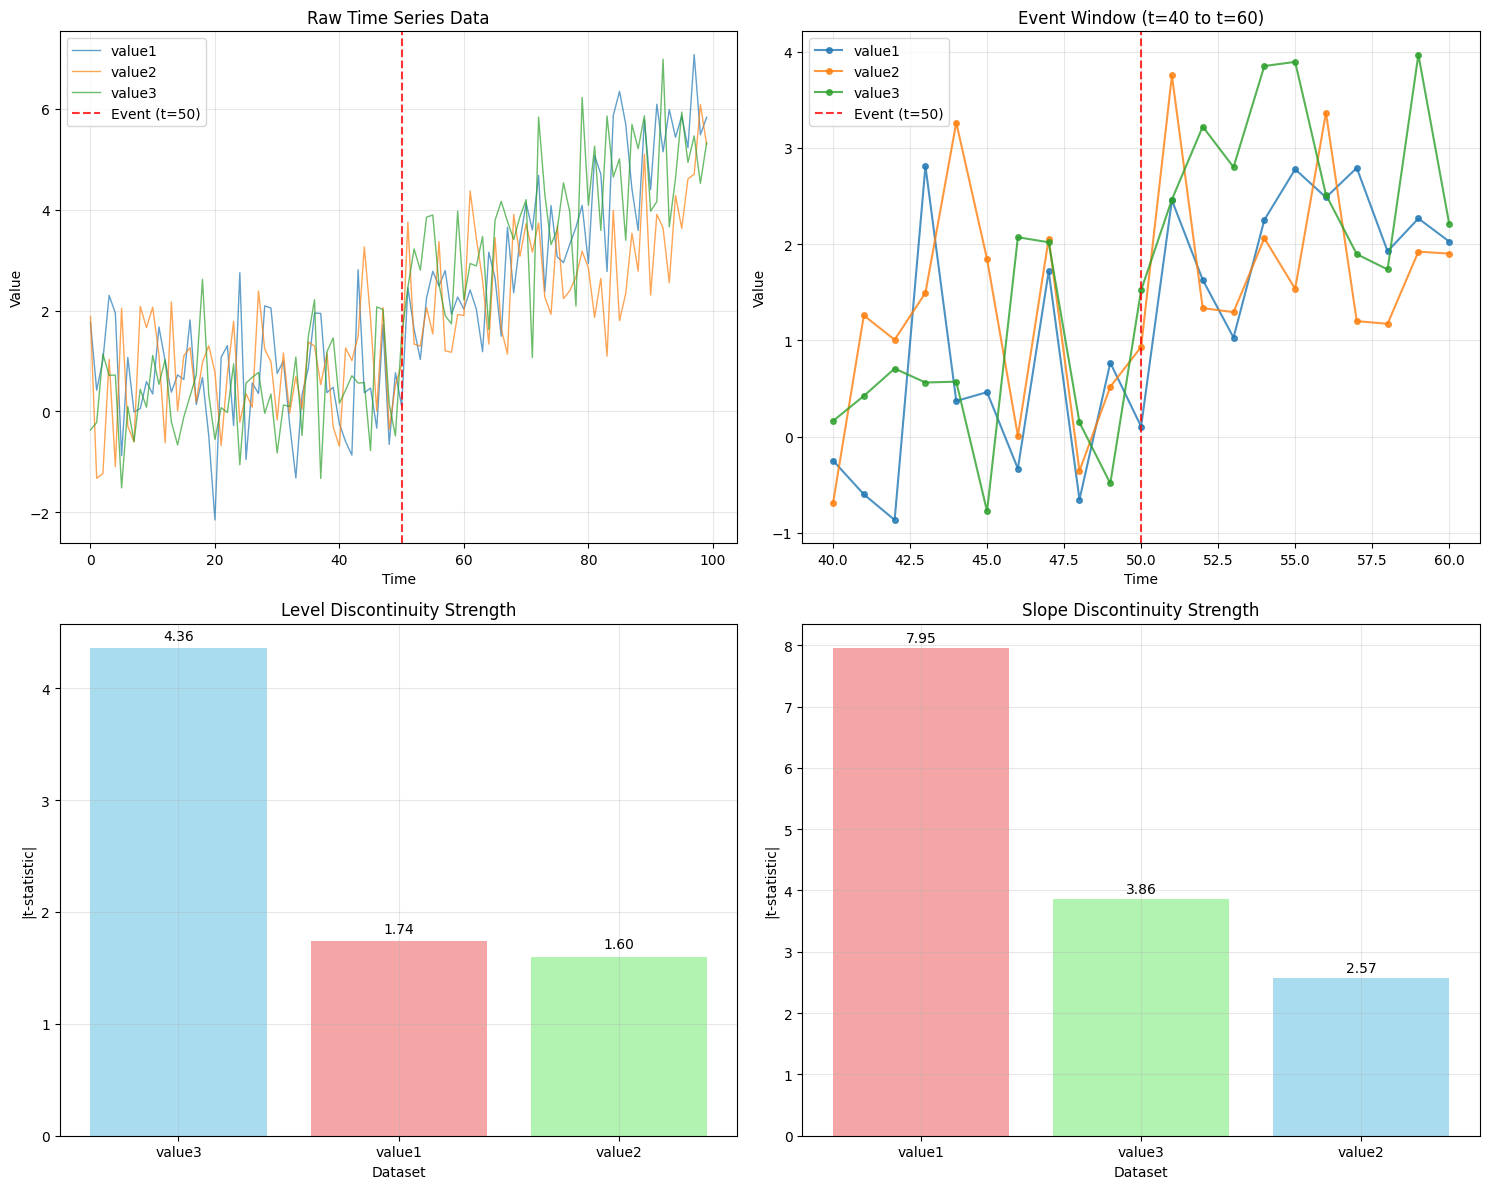

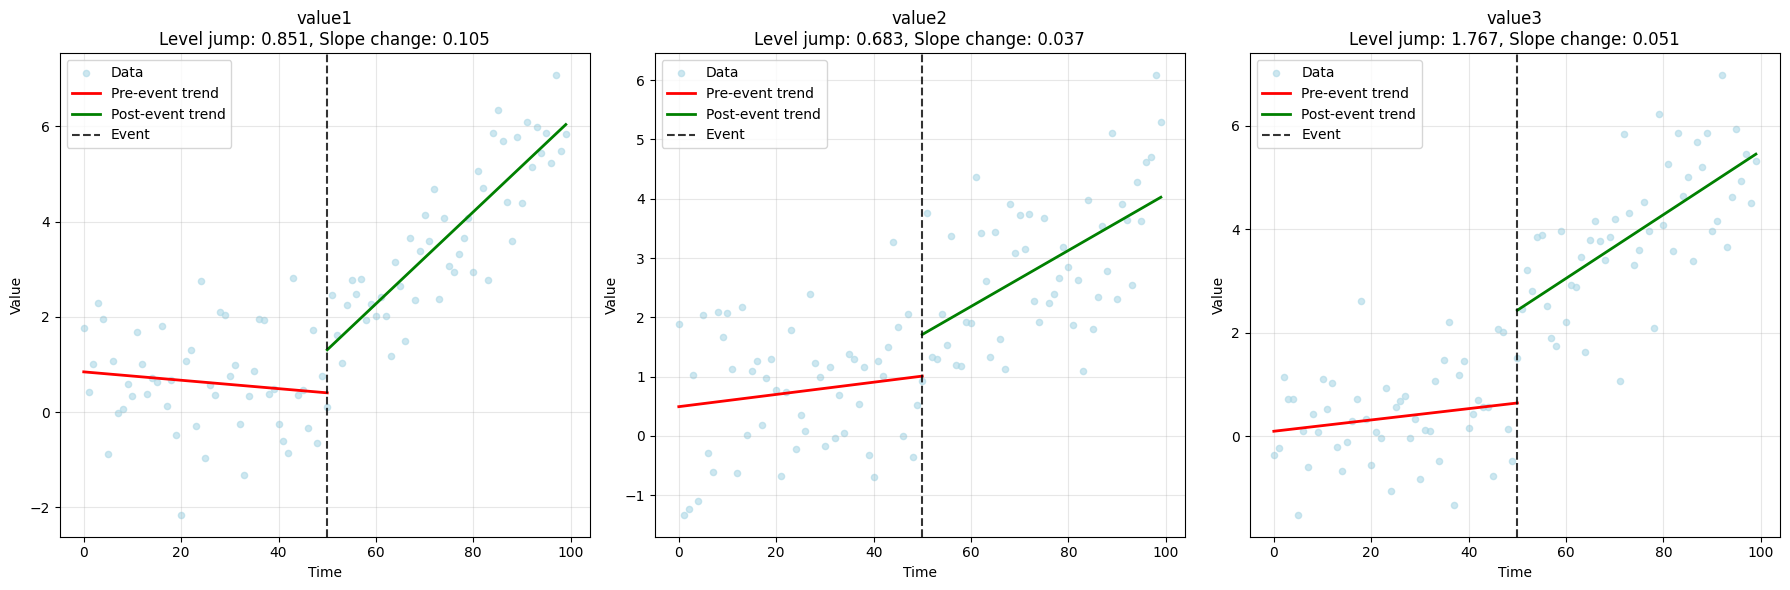

FINAL ANSWERS
Question 1 - Strongest VALUE discontinuity:
Answer: Option C (value3)

Question 2 - Weakest DERIVATIVE discontinuity:
Answer: Option C (value2)


In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Raw time series data
for col in value_columns:
    ax1.plot(df_3_1['time'], df_3_1[col], alpha=0.7, label=col, linewidth=1)

ax1.axvline(x=50, color='red', linestyle='--', alpha=0.8, label='Event (t=50)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Raw Time Series Data')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Focus on event window
event_window = df_3_1[(df_3_1['time'] >= 40) & (df_3_1['time'] <= 60)]
for col in value_columns:
    ax2.plot(event_window['time'], event_window[col], 'o-', alpha=0.8, label=col, markersize=4)

ax2.axvline(x=50, color='red', linestyle='--', alpha=0.8, label='Event (t=50)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Event Window (t=40 to t=60)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Level discontinuity comparison
cols = [effect[0] for effect in level_effects_sorted]
coefs = [effect[1] for effect in level_effects_sorted]
t_stats = [abs(effect[2]) for effect in level_effects_sorted]

x_pos = np.arange(len(cols))
bars1 = ax3.bar(x_pos, t_stats, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_xlabel('Dataset')
ax3.set_ylabel('|t-statistic|')
ax3.set_title('Level Discontinuity Strength')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cols)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, t_stat in zip(bars1, t_stats):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{t_stat:.2f}', ha='center', va='bottom')

# Plot 4: Slope discontinuity comparison
cols_slope = [effect[0] for effect in slope_effects_sorted]
t_stats_slope = [abs(effect[2]) for effect in slope_effects_sorted]

x_pos_slope = np.arange(len(cols_slope))
bars2 = ax4.bar(x_pos_slope, t_stats_slope, alpha=0.7, color=['lightcoral', 'lightgreen', 'skyblue'])
ax4.set_xlabel('Dataset')
ax4.set_ylabel('|t-statistic|')
ax4.set_title('Slope Discontinuity Strength')
ax4.set_xticks(x_pos_slope)
ax4.set_xticklabels(cols_slope)
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, t_stat in zip(bars2, t_stats_slope):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{t_stat:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(value_columns):
    ax = axes[i]
    
    # Plot original data
    ax.scatter(df_3_1['time'], df_3_1[col], alpha=0.6, s=20, color='lightblue', label='Data')
    
    # Fit and plot the discontinuity model
    X_full = df_3_1[['time', 'post_event', 'interaction']]
    reg_full = LinearRegression()
    reg_full.fit(X_full, df_3_1[col])
    
    # Create smooth prediction lines for before and after the event
    time_before = np.linspace(0, 50, 100)
    time_after = np.linspace(50, 99, 100)
    
    # Before event: Y = α + β₁*time
    X_before = np.column_stack([time_before, np.zeros(len(time_before)), np.zeros(len(time_before))])
    y_before = reg_full.predict(X_before)
    
    # After event: Y = α + β₁*time + β₂ + β₃*(time-50)
    post_event_after = np.ones(len(time_after))
    interaction_after = time_after - 50
    X_after = np.column_stack([time_after, post_event_after, interaction_after])
    y_after = reg_full.predict(X_after)
    
    ax.plot(time_before, y_before, 'r-', linewidth=2, label='Pre-event trend')
    ax.plot(time_after, y_after, 'g-', linewidth=2, label='Post-event trend')
    ax.axvline(x=50, color='black', linestyle='--', alpha=0.8, label='Event')
    
    # Add discontinuity information
    level_jump = all_results[col]['level_jump']['coefficient']
    slope_change = all_results[col]['slope_change']['slope_coefficient']
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'{col}\nLevel jump: {level_jump:.3f}, Slope change: {slope_change:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("FINAL ANSWERS")

print(f"Question 1 - Strongest VALUE discontinuity:")
print(f"Answer: Option {level_answer_map[strongest_level]} ({strongest_level})")

print(f"\nQuestion 2 - Weakest DERIVATIVE discontinuity:")  
print(f"Answer: Option {slope_answer_map[weakest_slope]} ({weakest_slope})")

For questions 3 to 5:  

Given a dataset with treatment and control data having “before” and “after” parts, apply a differences-in-differences regression.  
Use homework_3.2.a.csv and homework_3.2.b.csv. 

In [13]:
# Load the datasets
df_a = pd.read_csv('homework_3.2.a.csv')
df_b = pd.read_csv('homework_3.2.b.csv')

print("Dataset A (Group 1) shape:", df_a.shape)
print("Dataset B (Group 2) shape:", df_b.shape)

print("\nDataset A preview:")
print(df_a.head())

print("\nDataset B preview:")
print(df_b.head())

Dataset A (Group 1) shape: (1000, 4)
Dataset B (Group 2) shape: (1000, 4)

Dataset A preview:
   Unnamed: 0  group1  time1  outcome1
0           0       0      0  0.882026
1           1       0      1  1.600079
2           2       0      0  0.489369
3           3       0      1  2.520447
4           4       0      0  0.933779

Dataset B preview:
   Unnamed: 0  group2  time2  outcome2
0           0       0      0  0.667155
1           1       0      1  2.470969
2           2       0      0 -0.506778
3           3       0      1  1.525657
4           4       0      0  0.273664


In [14]:
# Analyze the 2x2 structure for each dataset
print("Dataset A - Group and Time Distribution:")
print(pd.crosstab(df_a['group1'], df_a['time1'], margins=True))

print("\nDataset B - Group and Time Distribution:")
print(pd.crosstab(df_b['group2'], df_b['time2'], margins=True))

# Create summary statistics for each cell of the 2x2 table
def analyze_did_structure(df, group_col, time_col, outcome_col, dataset_name):
    """Analyze the 2x2 structure for differences-in-differences"""
    
    print(f"\n{dataset_name} - 2x2 Summary Statistics:")
    
    # Calculate means for each cell
    means_table = df.groupby([group_col, time_col])[outcome_col].agg(['count', 'mean', 'std']).round(4)
    print("Count, Mean, and Std for each cell:")
    print(means_table)
    
    # Extract the four key values for DID calculation
    control_before = df[(df[group_col] == 0) & (df[time_col] == 0)][outcome_col].mean()
    control_after = df[(df[group_col] == 0) & (df[time_col] == 1)][outcome_col].mean()
    treatment_before = df[(df[group_col] == 1) & (df[time_col] == 0)][outcome_col].mean()
    treatment_after = df[(df[group_col] == 1) & (df[time_col] == 1)][outcome_col].mean()
    
    print(f"\nKey Means:")
    print(f"Control Before (0,0):    {control_before:.4f}")
    print(f"Control After (0,1):     {control_after:.4f}")
    print(f"Treatment Before (1,0):  {treatment_before:.4f}")
    print(f"Treatment After (1,1):   {treatment_after:.4f}")
    
    # Calculate simple differences
    control_change = control_after - control_before
    treatment_change = treatment_after - treatment_before
    
    print(f"\nSimple Changes:")
    print(f"Control change (time effect):     {control_change:.4f}")
    print(f"Treatment change (time + treatment): {treatment_change:.4f}")
    
    # Calculate DID estimate (manual calculation)
    did_manual = treatment_change - control_change
    print(f"\nDID Estimate (Manual): {did_manual:.4f}")
    print(f"This is: (Treatment After - Treatment Before) - (Control After - Control Before)")
    print(f"       = ({treatment_after:.4f} - {treatment_before:.4f}) - ({control_after:.4f} - {control_before:.4f})")
    print(f"       = {treatment_change:.4f} - {control_change:.4f} = {did_manual:.4f}")
    
    return {
        'control_before': control_before,
        'control_after': control_after,
        'treatment_before': treatment_before,
        'treatment_after': treatment_after,
        'control_change': control_change,
        'treatment_change': treatment_change,
        'did_manual': did_manual
    }

# Analyze both datasets
results_a = analyze_did_structure(df_a, 'group1', 'time1', 'outcome1', "DATASET A (Group 1)")
results_b = analyze_did_structure(df_b, 'group2', 'time2', 'outcome2', "DATASET B (Group 2)")

Dataset A - Group and Time Distribution:
time1     0    1   All
group1                
0       251  250   501
1       249  250   499
All     500  500  1000

Dataset B - Group and Time Distribution:
time2     0    1   All
group2                
0       251  250   501
1       249  250   499
All     500  500  1000

DATASET A (Group 1) - 2x2 Summary Statistics:
Count, Mean, and Std for each cell:
              count    mean     std
group1 time1                       
0      0        251 -0.0258  0.5069
       1        250  1.4014  0.4919
1      0        249  1.9604  0.4676
       1        250  4.0735  0.5095

Key Means:
Control Before (0,0):    -0.0258
Control After (0,1):     1.4014
Treatment Before (1,0):  1.9604
Treatment After (1,1):   4.0735

Simple Changes:
Control change (time effect):     1.4272
Treatment change (time + treatment): 2.1131

DID Estimate (Manual): 0.6858
This is: (Treatment After - Treatment Before) - (Control After - Control Before)
       = (4.0735 - 1.9604) - (1.4

In [15]:
print("""
Standard DID regression model:
Y = α + β₁*Group + β₂*Time + β₃*(Group × Time) + ε

Where:
- Group = 1 for treatment group, 0 for control
- Time = 1 for after period, 0 for before  
- Group × Time = interaction term
- β₃ = DID treatment effect (coefficient of interest)
""")

def run_did_regression(df, group_col, time_col, outcome_col, dataset_name):
    """Run differences-in-differences regression"""
    
    print(f"\n{dataset_name} Regression:")
    
    # Create interaction term
    df_reg = df.copy()
    df_reg['interaction'] = df_reg[group_col] * df_reg[time_col]
    
    # Set up regression
    X = df_reg[[group_col, time_col, 'interaction']]
    y = df_reg[outcome_col]
    
    # Fit regression
    reg = LinearRegression()
    reg.fit(X, y)
    
    # Calculate standard errors manually
    y_pred = reg.predict(X)
    residuals = y - y_pred
    n = len(y)
    k = X.shape[1] + 1  # +1 for intercept
    mse = np.sum(residuals**2) / (n - k)
    
    # Create design matrix with intercept
    X_with_intercept = np.column_stack([np.ones(len(X)), X])
    
    # Calculate covariance matrix
    try:
        cov_matrix = mse * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        std_errors = np.sqrt(np.diag(cov_matrix))
        
        # Extract results
        intercept = reg.intercept_
        group_coef = reg.coef_[0]
        time_coef = reg.coef_[1] 
        interaction_coef = reg.coef_[2]  # This is the DID estimate
        
        # Standard errors
        intercept_se = std_errors[0]
        group_se = std_errors[1]
        time_se = std_errors[2]
        interaction_se = std_errors[3]
        
        # t-statistics and p-values
        t_intercept = intercept / intercept_se
        t_group = group_coef / group_se
        t_time = time_coef / time_se
        t_interaction = interaction_coef / interaction_se
        
        # Degrees of freedom
        df_resid = n - k
        
        p_intercept = 2 * (1 - stats.t.cdf(abs(t_intercept), df_resid))
        p_group = 2 * (1 - stats.t.cdf(abs(t_group), df_resid))
        p_time = 2 * (1 - stats.t.cdf(abs(t_time), df_resid))
        p_interaction = 2 * (1 - stats.t.cdf(abs(t_interaction), df_resid))
        
        print(f"Regression Results:")
        print(f"─────────────────────────────────────────")
        print(f"Intercept (α):        {intercept:.6f} (SE: {intercept_se:.6f}, t: {t_intercept:.3f}, p: {p_intercept:.6f})")
        print(f"Group (β₁):           {group_coef:.6f} (SE: {group_se:.6f}, t: {t_group:.3f}, p: {p_group:.6f})")
        print(f"Time (β₂):            {time_coef:.6f} (SE: {time_se:.6f}, t: {t_time:.3f}, p: {p_time:.6f})")
        print(f"DID Effect (β₃):      {interaction_coef:.6f} (SE: {interaction_se:.6f}, t: {t_interaction:.3f}, p: {p_interaction:.6f})")
        print(f"─────────────────────────────────────────")
        print(f"R²:                   {reg.score(X, y):.6f}")
        print(f"Observations:         {n}")
        
        # Significance stars
        def get_significance_stars(p_val):
            if p_val < 0.001:
                return "***"
            elif p_val < 0.01:
                return "**"
            elif p_val < 0.05:
                return "*"
            else:
                return ""
        
        print(f"\nDID Treatment Effect: {interaction_coef:.6f} {get_significance_stars(p_interaction)}")
        
        return {
            'intercept': intercept,
            'group_coef': group_coef,
            'time_coef': time_coef,
            'did_effect': interaction_coef,
            'did_se': interaction_se,
            'did_t_stat': t_interaction,
            'did_p_value': p_interaction,
            'r_squared': reg.score(X, y),
            'n_obs': n
        }
        
    except np.linalg.LinAlgError:
        print("Error: Could not compute standard errors due to singular matrix")
        return None

# Run regressions for both datasets
print(f"\n{'='*30} GROUP 1 ANALYSIS {'='*30}")
reg_results_a = run_did_regression(df_a, 'group1', 'time1', 'outcome1', "GROUP 1")

print(f"\n{'='*30} GROUP 2 ANALYSIS {'='*30}")
reg_results_b = run_did_regression(df_b, 'group2', 'time2', 'outcome2', "GROUP 2")


Standard DID regression model:
Y = α + β₁*Group + β₂*Time + β₃*(Group × Time) + ε

Where:
- Group = 1 for treatment group, 0 for control
- Time = 1 for after period, 0 for before  
- Group × Time = interaction term
- β₃ = DID treatment effect (coefficient of interest)


============================== GROUP 1 ANALYSIS ==============================

GROUP 1 Regression:
Regression Results:
─────────────────────────────────────────
Intercept (α):        -0.025849 (SE: 0.031199, t: -0.829, p: 0.407566)
Group (β₁):           1.986278 (SE: 0.044210, t: 44.928, p: 0.000000)
Time (β₂):            1.427213 (SE: 0.044166, t: 32.315, p: 0.000000)
DID Effect (β₃):      0.685847 (SE: 0.062522, t: 10.970, p: 0.000000)
─────────────────────────────────────────
R²:                   0.899276
Observations:         1000

DID Treatment Effect: 0.685847 ***

============================== GROUP 2 ANALYSIS ==============================

GROUP 2 Regression:
Regression Results:
────────────────────────────

In [16]:
print("Question 3: Which dataset likely has the LARGEST treatment effect?")
print("──────────────────────────────────────────────────────────────")

effect_a = reg_results_a['did_effect'] if reg_results_a else results_a['did_manual']
effect_b = reg_results_b['did_effect'] if reg_results_b else results_b['did_manual']

print(f"Group 1 DID Effect: {effect_a:.6f}")
print(f"Group 2 DID Effect: {effect_b:.6f}")

if abs(effect_a) > abs(effect_b):
    largest_effect = "Group 1"
    q3_answer = "B"
else:
    largest_effect = "Group 2"
    q3_answer = "A"
    
print(f"\nLargest effect (by absolute magnitude): {largest_effect}")
print(f"Question 3 Answer: Option {q3_answer} ({largest_effect})")

print("\nQuestion 4: Which dataset has the most statistically significant treatment effect?")
print("──────────────────────────────────────────────────────────────────────────────")

if reg_results_a and reg_results_b:
    t_stat_a = abs(reg_results_a['did_t_stat'])
    t_stat_b = abs(reg_results_b['did_t_stat'])
    p_val_a = reg_results_a['did_p_value']
    p_val_b = reg_results_b['did_p_value']
    
    print(f"Group 1: t-statistic = {t_stat_a:.4f}, p-value = {p_val_a:.6f}")
    print(f"Group 2: t-statistic = {t_stat_b:.4f}, p-value = {p_val_b:.6f}")
    
    if t_stat_a > t_stat_b:
        most_significant = "Group 1"
        q4_answer = "A"
    else:
        most_significant = "Group 2"
        q4_answer = "B"
        
    print(f"\nMost statistically significant: {most_significant}")
    print(f"Question 4 Answer: Option {q4_answer} ({most_significant})")

print("\nQuestion 5: Which is closest to the treatment effect for Group 2?")
print("─────────────────────────────────────────────────────────────")

group2_effect = effect_b
print(f"Group 2 DID Effect: {group2_effect:.6f}")

options_q5 = [4.209, 0.5831, 1.248]
labels_q5 = ['A', 'B', 'C']
differences_q5 = [abs(group2_effect - opt) for opt in options_q5]
closest_idx_q5 = differences_q5.index(min(differences_q5))

print(f"\nOptions:")
for i, (label, option) in enumerate(zip(labels_q5, options_q5)):
    marker = " ← CLOSEST" if i == closest_idx_q5 else ""
    print(f"Option {label}: {option} (diff: {differences_q5[i]:.6f}){marker}")

print(f"\nQuestion 5 Answer: Option {labels_q5[closest_idx_q5]} ({options_q5[closest_idx_q5]})")

Question 3: Which dataset likely has the LARGEST treatment effect?
──────────────────────────────────────────────────────────────
Group 1 DID Effect: 0.685847
Group 2 DID Effect: 1.349859

Largest effect (by absolute magnitude): Group 2
Question 3 Answer: Option A (Group 2)

Question 4: Which dataset has the most statistically significant treatment effect?
──────────────────────────────────────────────────────────────────────────────
Group 1: t-statistic = 10.9696, p-value = 0.000000
Group 2: t-statistic = 9.1798, p-value = 0.000000

Most statistically significant: Group 1
Question 4 Answer: Option A (Group 1)

Question 5: Which is closest to the treatment effect for Group 2?
─────────────────────────────────────────────────────────────
Group 2 DID Effect: 1.349859

Options:
Option A: 4.209 (diff: 2.859141)
Option B: 0.5831 (diff: 0.766759)
Option C: 1.248 (diff: 0.101859) ← CLOSEST

Question 5 Answer: Option C (1.248)


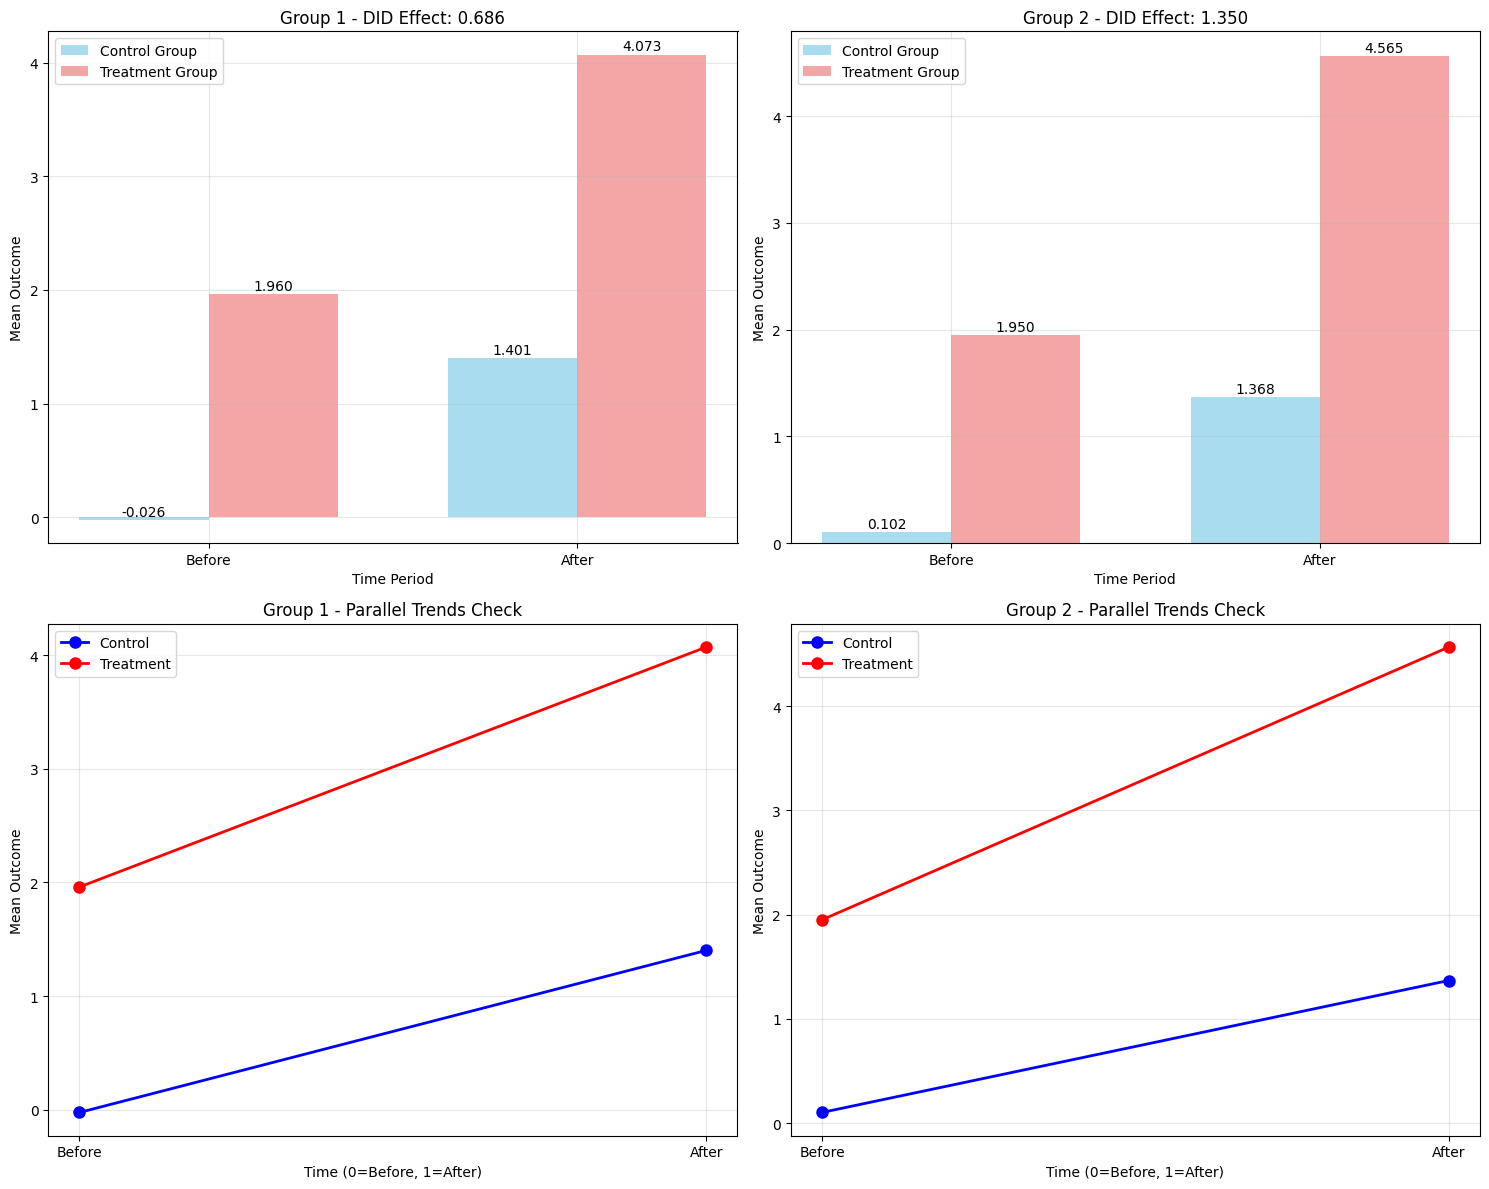

In [17]:
# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Group 1 (Dataset A) - Mean outcomes by group and time
group1_means = df_a.groupby(['group1', 'time1'])['outcome1'].mean().unstack()
groups = ['Control', 'Treatment']
times = ['Before', 'After']

x = np.arange(2)
width = 0.35

bars1 = ax1.bar(x - width/2, [group1_means.loc[0, 0], group1_means.loc[0, 1]], 
               width, label='Control Group', alpha=0.7, color='skyblue')
bars2 = ax1.bar(x + width/2, [group1_means.loc[1, 0], group1_means.loc[1, 1]], 
               width, label='Treatment Group', alpha=0.7, color='lightcoral')

ax1.set_xlabel('Time Period')
ax1.set_ylabel('Mean Outcome')
ax1.set_title(f'Group 1 - DID Effect: {effect_a:.3f}')
ax1.set_xticks(x)
ax1.set_xticklabels(times)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

# Plot 2: Group 2 (Dataset B) - Mean outcomes by group and time
group2_means = df_b.groupby(['group2', 'time2'])['outcome2'].mean().unstack()

bars3 = ax2.bar(x - width/2, [group2_means.loc[0, 0], group2_means.loc[0, 1]], 
               width, label='Control Group', alpha=0.7, color='skyblue')
bars4 = ax2.bar(x + width/2, [group2_means.loc[1, 0], group2_means.loc[1, 1]], 
               width, label='Treatment Group', alpha=0.7, color='lightcoral')

ax2.set_xlabel('Time Period')
ax2.set_ylabel('Mean Outcome')
ax2.set_title(f'Group 2 - DID Effect: {effect_b:.3f}')
ax2.set_xticks(x)
ax2.set_xticklabels(times)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

# Plot 3: Parallel trends visualization for Group 1
time_points = [0, 1]
control_means_a = [group1_means.loc[0, 0], group1_means.loc[0, 1]]
treatment_means_a = [group1_means.loc[1, 0], group1_means.loc[1, 1]]

ax3.plot(time_points, control_means_a, 'o-', label='Control', linewidth=2, markersize=8, color='blue')
ax3.plot(time_points, treatment_means_a, 'o-', label='Treatment', linewidth=2, markersize=8, color='red')
ax3.set_xlabel('Time (0=Before, 1=After)')
ax3.set_ylabel('Mean Outcome')
ax3.set_title('Group 1 - Parallel Trends Check')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Before', 'After'])

# Plot 4: Parallel trends visualization for Group 2
control_means_b = [group2_means.loc[0, 0], group2_means.loc[0, 1]]
treatment_means_b = [group2_means.loc[1, 0], group2_means.loc[1, 1]]

ax4.plot(time_points, control_means_b, 'o-', label='Control', linewidth=2, markersize=8, color='blue')
ax4.plot(time_points, treatment_means_b, 'o-', label='Treatment', linewidth=2, markersize=8, color='red')
ax4.set_xlabel('Time (0=Before, 1=After)')
ax4.set_ylabel('Mean Outcome')
ax4.set_title('Group 2 - Parallel Trends Check')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['Before', 'After'])

plt.tight_layout()
plt.show()

In [18]:
summary_df = pd.DataFrame({
    'Group 1': [
        f"{effect_a:.6f}",
        f"{reg_results_a['did_se']:.6f}" if reg_results_a else "N/A",
        f"{reg_results_a['did_t_stat']:.4f}" if reg_results_a else "N/A",
        f"{reg_results_a['did_p_value']:.6f}" if reg_results_a else "N/A"
    ],
    'Group 2': [
        f"{effect_b:.6f}",
        f"{reg_results_b['did_se']:.6f}" if reg_results_b else "N/A",
        f"{reg_results_b['did_t_stat']:.4f}" if reg_results_b else "N/A",
        f"{reg_results_b['did_p_value']:.6f}" if reg_results_b else "N/A"
    ]
}, index=['DID Effect', 'Standard Error', 't-statistic', 'p-value'])

print(summary_df)

print(f"\nFINAL ANSWERS:")
print(f"Question 3: Option {q3_answer} ({largest_effect}) - Largest treatment effect")
print(f"Question 4: Option {q4_answer} ({most_significant}) - Most statistically significant")
print(f"Question 5: Option {labels_q5[closest_idx_q5]} ({options_q5[closest_idx_q5]}) - Closest to Group 2 effect")

print("\nAnalysis complete!")

# Create the df_3_2 as requested
df_3_2 = pd.concat([
    df_a.assign(dataset='Group1').rename(columns={'group1': 'group', 'time1': 'time', 'outcome1': 'outcome'}),
    df_b.assign(dataset='Group2').rename(columns={'group2': 'group', 'time2': 'time', 'outcome2': 'outcome'})
], ignore_index=True)

print(f"\nCreated df_3_2 with shape: {df_3_2.shape}")
print("Preview of df_3_2:")
print(df_3_2.head())

                 Group 1   Group 2
DID Effect      0.685847  1.349859
Standard Error  0.062522  0.147047
t-statistic      10.9696    9.1798
p-value         0.000000  0.000000

FINAL ANSWERS:
Question 3: Option A (Group 2) - Largest treatment effect
Question 4: Option A (Group 1) - Most statistically significant
Question 5: Option C (1.248) - Closest to Group 2 effect

Analysis complete!

Created df_3_2 with shape: (2000, 5)
Preview of df_3_2:
   Unnamed: 0  group  time   outcome dataset
0           0      0     0  0.882026  Group1
1           1      0     1  1.600079  Group1
2           2      0     0  0.489369  Group1
3           3      0     1  2.520447  Group1
4           4      0     0  0.933779  Group1
